# Mask R-CNN - Inspect Malaria Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!ls

drive  sample_data


In [0]:
import os
os.chdir('drive/My Drive/Mask_RCNN')

In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 204kB 8.3MB/s 
     |████████████████████████████████| 163kB 20.3MB/s 


In [5]:
!python3 setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/Copy of __init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/

In [6]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
# ROOT_DIR = os.path.abspath("../../")
ROOT_DIR = '.'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

#from samples.malaria import malaria
from samples.malaria.derong_testing_environ import malaria_derong

%matplotlib inline 

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = ROOT_DIR+'/logs'

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
# BALLON_WEIGHTS_PATH = "/path/to/mask_rcnn_balloon.h5"  # TODO: update this path
MALARIA_WEIGHTS_PATH = ROOT_DIR+'/mask_rcnn_malaria_final.h5'

Using TensorFlow backend.


## Configurations

In [0]:
config = malaria_derong.MalariaConfig()
# MALARIA_DIR = ROOT_DIR+'/datasets/malaria'
MALARIA_DIR = ROOT_DIR+'/datasets/malaria_derong_testing'

In [8]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [11]:
# Load validation dataset
dataset = malaria_derong.CellDataset()
dataset.load_cell(MALARIA_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 64
Classes: ['BG', 'uninfectedretic', 'ring', 'trophozoite', 'schizont']


## Load Model

In [12]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [13]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", MALARIA_WEIGHTS_PATH)
model.load_weights(MALARIA_WEIGHTS_PATH, by_name=True)

Loading weights  ./mask_rcnn_malaria_final.h5








## Run Detection

In [14]:
image_id = 14
#image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

image ID: cell.ring_26.png (14) ./datasets/malaria_derong_testing/val/ring_26.png


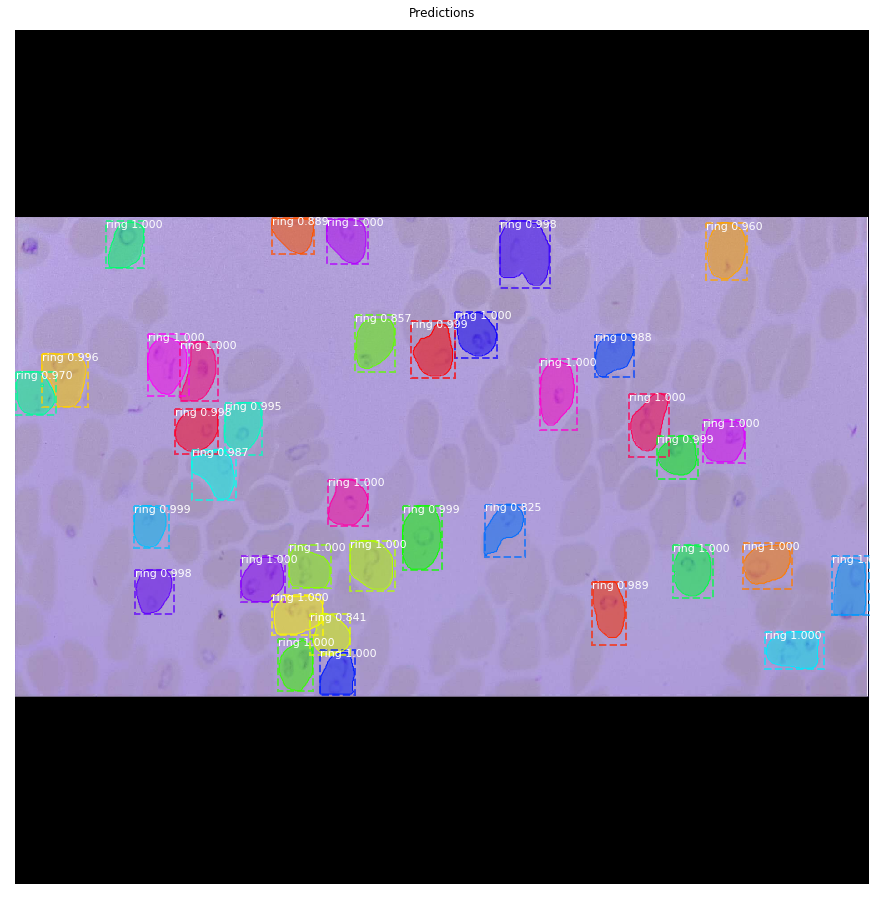

In [15]:
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

In [0]:
splash = malaria_derong.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Testing with specific images

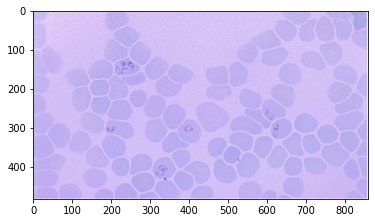

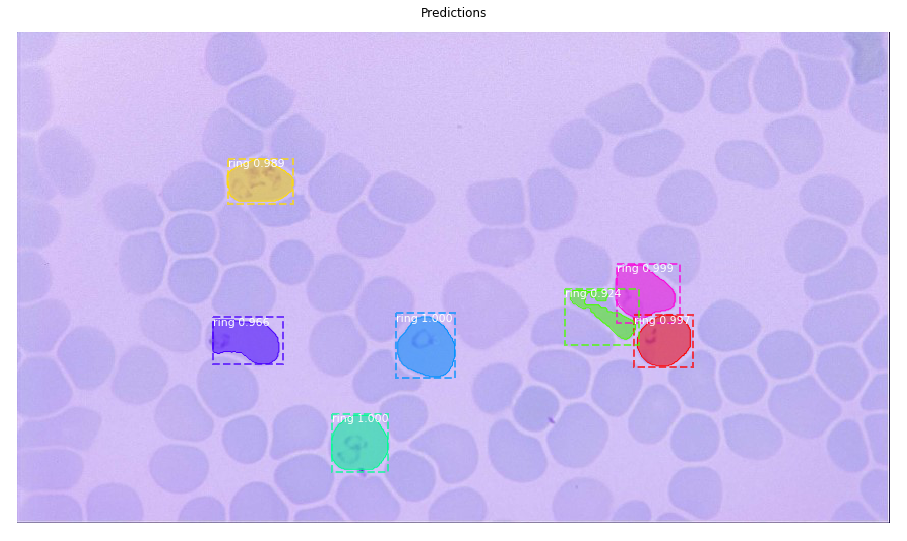

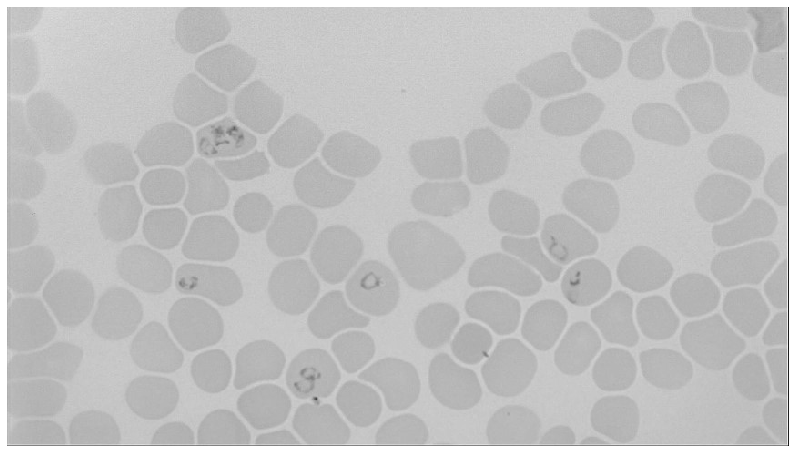

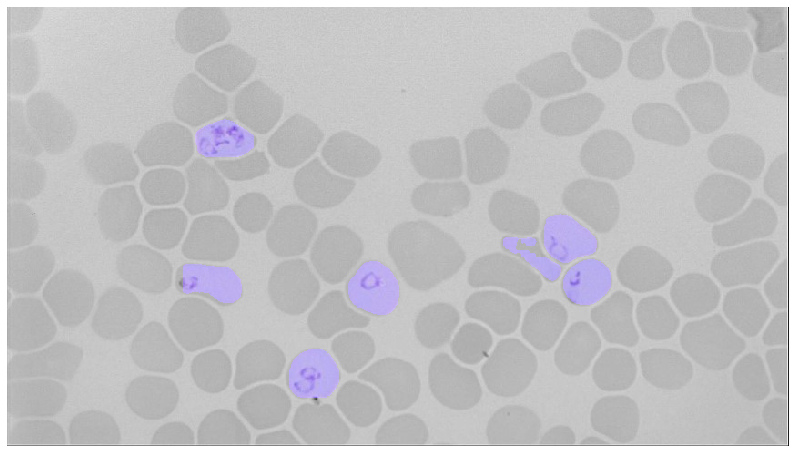

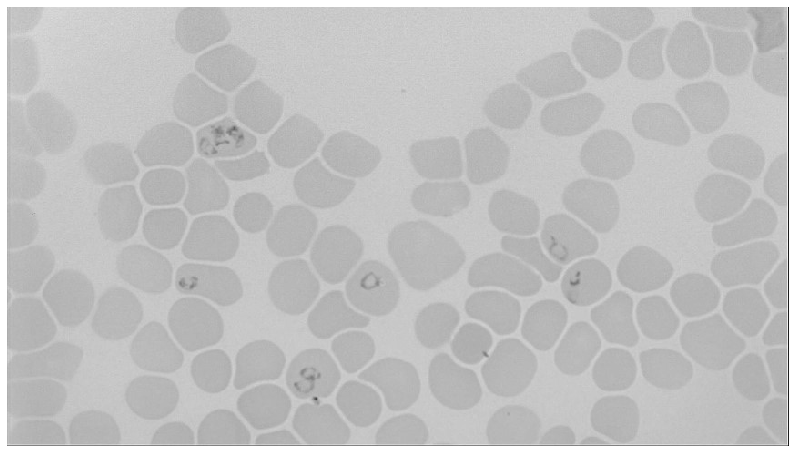

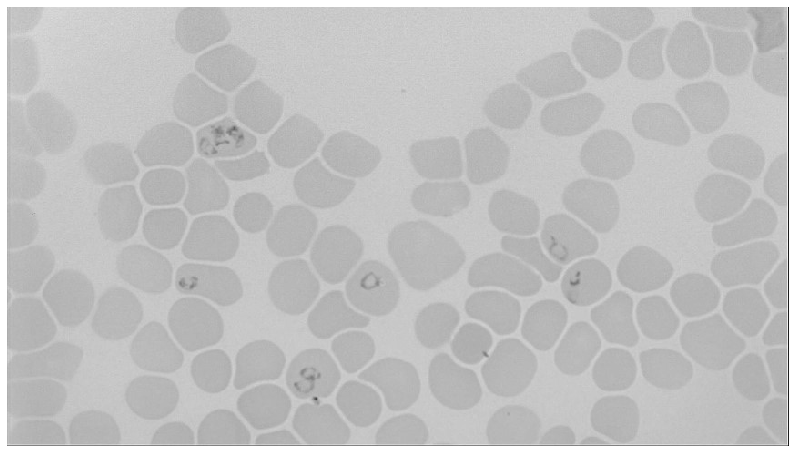

NameError: ignored

In [16]:
img_path = "./datasets/malaria_derong_testing/testing_images/image_1.jpg"

img_test = plt.imread(img_path)
plt.imshow(img_test)

# Run object detection
results = model.detect([img_test], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(img_test, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

mask_uninfectedretic = []
mask_ring = []
mask_trophozoite = []
mask_schizont = []

for i in range(len(r['class_ids'])):
  el = r['class_ids'][i]
  col = np.transpose(r['masks'][:,:,i])
  
  if el == 1:
    mask_uninfectedretic.append(col)
  if el == 2:
    mask_ring.append(col)
  if el == 3:
    mask_trophozoite.append(col)
  if el == 4:
    mask_schizont.append(col)
    
mask_uninfectedretic = np.transpose(np.array(mask_uninfectedretic))
mask_ring = np.transpose(np.array(mask_ring))
mask_trophozoite = np.transpose(np.array(mask_trophozoite))
mask_schizont = np.transpose(np.array(mask_schizont))
    
splash = malaria_derong.color_splash(img_test, np.array(mask_uninfectedretic))
display_images([splash], cols=1)

splash = malaria_derong.color_splash(img_test, np.array(mask_ring))
display_images([splash], cols=1)

splash = malaria_derong.color_splash(img_test, np.array(mask_trophozoite))
display_images([splash], cols=1)

splash = malaria_derong.color_splash(img_test, np.array(mask_schizont))
display_images([splash], cols=1)

# Get predictions of mask head
mrcnn = model.run_graph([img_test], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

#print("{} detections: {}".format(
#    det_count, np.array(dataset.class_names)[det_class_ids]))

ls = list(np.array(dataset.class_names)[det_class_ids])

print("The number of normocytes is: {}".format(totalcellcount(img_path)-det_count))
print("The number of uninfected reticulocytes is: {}".format(ls.count("uninfectedretic")))
print("The number of rings is: {}".format(ls.count("ring")))
print("The number of trophozoites is: {}".format(ls.count("trophozoite")))
print("The number of schizonts is: {}".format(ls.count("schizont")))


In [0]:
from os import listdir
from os.path import isfile, join
mypath = "./datasets/malaria_derong_testing/testing_images"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = sorted(onlyfiles)

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import watershed
from scipy.ndimage.morphology import binary_fill_holes
import imutils

def totalcellcount(filename):
  img = cv2.imread(filename)
  
  #===Increase the contrast of the image using histogram equalisation===
  #converting the color space of the image 
  gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  gray_img = cv2.cvtColor(gray_img,cv2.COLOR_GRAY2BGR)


  #LAB color space 
  #L = lightness / intensity
  #a = color component ranging from Green to Magenta
  #b = color component ranging from Blue to Yellow
  lab= cv2.cvtColor(gray_img, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)

  #clahe = histogram equalisation
  #to improve contrast of the image
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  cl = clahe.apply(l)
  limg = cv2.merge((cl,a,b))
  final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
  final = cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)
  #cv2.imshow("final",final)

  blur = cv2.blur(final,(3,3))

  #===end===

  th, threshed = cv2.threshold(blur, 175, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

  #use binary_fill_holes to create mask for watershed
  test1 = binary_fill_holes(threshed)

  #===Morphological Opening===
  #https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
  #Morphological Opening to remove small holes inside the foreground objects or black points on the object
  kernel5 = np.ones((5,5),np.uint8)
  kernel7 = np.ones((7,7),np.uint8)
  kernel2 = np.ones((2,2),np.uint8)
  kernel3 = np.ones((3,3),np.uint8)
  kernel4 = np.ones((4,4),np.uint8)

  opening = cv2.morphologyEx(threshed, cv2.MORPH_OPEN, kernel7)

  test = opening.copy()

  for i in range(9):
      test = cv2.erode(test,kernel5,iterations = 1)
      test = cv2.morphologyEx(test, cv2.MORPH_OPEN, kernel5)
      test = cv2.dilate(test, kernel2,iterations = 1)
      test = cv2.morphologyEx(test, cv2.MORPH_OPEN, kernel5)
      test = cv2.dilate(test, kernel3,iterations = 1)

  #https://www.pyimagesearch.com/2015/11/02/watershed-opencv/
  # Marker labelling
  ret, markers = cv2.connectedComponents(test)

  #Apply watershed
  labels = watershed(final,markers,mask=opening)

  #Count total number of cells and draw contour
  cell_count = 0
  for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
      if label == 0:
          continue

    # otherwise, allocate memory for the label region and draw
    # it on the mask
      mask = np.zeros(blur.shape, dtype="uint8")
      mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
      cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cnts = imutils.grab_contours(cnts)
      #c = max(cnts, key=cv2.contourArea)

      for cnt in cnts:
          if cv2.contourArea(cnt) > 300:
              cv2.drawContours(img, [cnt], -1, (0,255,0), 3)
              cell_count += 1
      
  return cell_count
  
  
def predict():
  start_time = time.time()
  normocyte_total = 0
  uninfectedretic_total = 0
  ring_total = 0
  trophozoite_total = 0
  schizont_total = 0
  error_count = 0
  analysed_count = 0
  error_ls = []

  for file in onlyfiles:
    img = plt.imread(mypath + "/" + file)
      # Get predictions of mask head
    mrcnn = model.run_graph([img], [
        ("detections", model.keras_model.get_layer("mrcnn_detection").output),
        ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ])
    # Get detection class IDs. Trim zero padding.
    det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
    det_count = np.where(det_class_ids == 0)[0][0]
    det_class_ids = det_class_ids[:det_count]

    cellcount = totalcellcount(mypath + "/" + file)
    
    if cellcount > det_count:
      ls = list(np.array(dataset.class_names)[det_class_ids])
      
      num_normocyte = cellcount - det_count
      print('\033[1m' + file + '\033[0m')
      print("Total: {}".format(cellcount))
      print("Normocytes: {}".format(num_normocyte))
      print("Uninfected Reticulocytes: {}".format(ls.count("uninfectedretic")))
      print("Rings: {}".format(ls.count("ring")))
      print("Trophozoites: {}".format(ls.count("trophozoite")))
      print("Schizonts: {}\n".format(ls.count("schizont")))
      
      normocyte_total += num_normocyte
      uninfectedretic_total += ls.count("uninfectedretic")
      ring_total += ls.count("ring")
      trophozoite_total += ls.count("trophozoite")
      schizont_total += ls.count("schizont")
      analysed_count += 1
      
    else:
      error_count += 1
      error_ls.append(file)
      
  infected = ring_total + trophozoite_total + schizont_total
  uninfected = normocyte_total + uninfectedretic_total
  parasitemia = round(infected/(uninfected+infected),3)
  
  print('\033[1m' + 'Sample Report' + '\033[0m')
  print("Parasitemia: {}%".format(100*parasitemia))
  print("Normocytes: {}".format(normocyte_total))
  print("Uninfected Reticulocytes: {}".format(uninfectedretic_total))
  print("Rings: {}".format(ring_total))
  print("Trophozoites: {}".format(trophozoite_total))
  print("Schizonts: {}\n".format(schizont_total))
  
  totalcount = analysed_count + error_count
  elapsed_time = time.time() - start_time
  print("Images processsed: {}".format(totalcount))
  if elapsed_time < 60:
    print("Time taken: {}s".format(round(elapsed_time,3)))
  else:
    minutes = int(elapsed_time//60)
    seconds = round(elapsed_time%60,3)
    print("Time taken: {}min {}s".format(minutes, seconds))
  print("Average time taken per image: {}s\n".format(round(elapsed_time/totalcount,3)))
  
  error_str = ', '.join(error_ls)
  print("Error in processing these images: {}".format(error_str))
  
def generate_masks(filename):
  
  img_test = plt.imread(mypath + "/" + filename) 

  # Run object detection
  results = model.detect([img_test], verbose=1)

  # Display results
  r = results[0]

  mask_uninfectedretic = []
  mask_ring = []
  mask_trophozoite = []
  mask_schizont = []

  for i in range(len(r['class_ids'])):
    el = r['class_ids'][i]
    col = np.transpose(r['masks'][:,:,i])

    if el == 1:
      mask_uninfectedretic.append(col)
    if el == 2:
      mask_ring.append(col)
    if el == 3:
      mask_trophozoite.append(col)
    if el == 4:
      mask_schizont.append(col)

  mask_uninfectedretic = np.transpose(np.array(mask_uninfectedretic))
  mask_ring = np.transpose(np.array(mask_ring))
  mask_trophozoite = np.transpose(np.array(mask_trophozoite))
  mask_schizont = np.transpose(np.array(mask_schizont))

  splash = malaria_derong.color_splash(img_test, np.array(mask_uninfectedretic))
  print('     \033[1m' + 'Uninfected Reticulocyte mask' + '\033[0m')
  display_images([splash],cols=1)

  splash = malaria_derong.color_splash(img_test, np.array(mask_ring))
  print('     \033[1m' + 'Ring mask' + '\033[0m')
  display_images([splash], cols=1)

  splash = malaria_derong.color_splash(img_test, np.array(mask_trophozoite))
  print('     \033[1m' + 'Trophozoite mask' + '\033[0m')
  display_images([splash], cols=1)

  splash = malaria_derong.color_splash(img_test, np.array(mask_schizont))
  print('     \033[1m' + 'Schizont mask' + '\033[0m')
  display_images([splash], cols=1)

# Predict

In [19]:
predict()

image_1.jpg
Total: 106
Normocytes: 99
Uninfected Reticulocytes: 0
Rings: 7
Trophozoites: 0
Schizonts: 0

image_10.jpg
Total: 96
Normocytes: 92
Uninfected Reticulocytes: 0
Rings: 0
Trophozoites: 0
Schizonts: 4

image_11.jpg
Total: 105
Normocytes: 96
Uninfected Reticulocytes: 0
Rings: 4
Trophozoites: 3
Schizonts: 2

image_12.jpg
Total: 101
Normocytes: 97
Uninfected Reticulocytes: 0
Rings: 2
Trophozoites: 0
Schizonts: 2

image_13.jpg
Total: 93
Normocytes: 90
Uninfected Reticulocytes: 0
Rings: 0
Trophozoites: 0
Schizonts: 3

image_14.jpg
Total: 95
Normocytes: 88
Uninfected Reticulocytes: 0
Rings: 3
Trophozoites: 2
Schizonts: 2

image_15.jpg
Total: 82
Normocytes: 72
Uninfected Reticulocytes: 0
Rings: 0
Trophozoites: 2
Schizonts: 8

image_16.jpg
Total: 114
Normocytes: 109
Uninfected Reticulocytes: 0
Rings: 0
Trophozoites: 4
Schizonts: 1

image_17.jpg
Total: 134
Normocytes: 125
Uninfected Reticulocytes: 0
Rings: 2
Trophozoites: 5
Schizonts: 2

image_18.jpg
Total: 80
Normocytes: 73
Uninfected 

In [0]:
filename = 'Image 1.jpg'

generate_masks(filename)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [0]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


In [0]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [0]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

In [0]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [0]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

In [0]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

In [0]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [0]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [0]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [0]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [0]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

In [0]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [0]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [0]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

#### Per-Class Non-Max Suppression

In [0]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [0]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [0]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [0]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [0]:
ls = list(np.array(dataset.class_names)[det_class_ids])

print("The number of uninfected reticulocytes is: {}".format(ls.count("uninfectedretic")))
print("The number of infected reticulocytes is: {}".format(ls.count("infectedretic")))
print("The number of rings is: {}".format(ls.count("ring")))
print("The number of schizonts is: {}".format(ls.count("schizont")))

In [0]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [0]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [0]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [0]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [0]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [0]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

In [0]:
import os
os.chdir('/content/drive/My Drive/Mask_RCNN/samples/malaria/derong_testing_environ')

In [0]:
!ls

In [0]:
!python3 malaria_derong.py train --dataset=../../../datasets/malaria_derong_testing/ --weights=../../../mask_rcnn_malaria_0020.h5